In [1]:
# !pip install git+https://github.com/wendlerc/latent_clip.git@renamed
!git clone https://github.com/jsonBackup/Latent-ReNO Latent-ReNO || echo "Folder already exists. Skipping clone."

import latent_clip
import torch
from PIL import Image
from matplotlib import pyplot as plt
from diffusers import AutoPipelineForText2Image, StableDiffusionXLPipeline
from huggingface_hub import hf_hub_download
import shutil
import os

from helper import download_and_rename_model

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CACHE_DIR = "./cache"

Cloning into 'Latent-ReNO'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 109 (delta 50), reused 74 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (109/109), 7.17 MiB | 40.13 MiB/s, done.
Resolving deltas: 100% (50/50), done.


### Download latent clip models

In [2]:
target_dir = "./models"
download_and_rename_model(
    "wendlerc/latent-clip-b-4-512-plus-34b-80k",
    "latent-clip-b-4-plus.pt",
    target_dir,
    filename="checkpoints/epoch_34.pt",
)
download_and_rename_model(
    "wendlerc/latent-clip-b-8-512-34b-80k",
    "latent-clip-b-8.pt",
    target_dir,
    filename="checkpoints/epoch_34.pt",
)

✅ latent-clip-b-4-plus.pt already exists. Skipping download.
✅ latent-clip-b-8.pt already exists. Skipping download.


In [3]:
models = {
    "B-8": {
        "model_name": "Latent-ViT-B-8-512",
        "pretrained": "./models/latent-clip-b-8.pt",
    },
    "B-4-plus": {
        "model_name": "Latent-ViT-B-4-512-plus",
        "pretrained": "./models/latent-clip-b-4-plus.pt",
    },
}
size = "B-4-plus"
model_name = models[size]["model_name"]
pretrained = models[size]["pretrained"]
model, _, preprocess = latent_clip.create_model_and_transforms(
    model_name, pretrained=pretrained, device=device
)
tokenizer = latent_clip.get_tokenizer(model_name)

INFO:root:Loaded Latent-ViT-B-4-512-plus model config.
INFO:root:Loading pretrained Latent-ViT-B-4-512-plus weights (./models/latent-clip-b-4-plus.pt).


# Classifying a single image

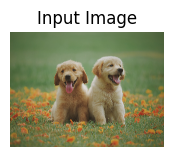

Label probs: [6.9730510e-07 1.1237008e-02 9.9315612e-06 9.8040181e-01 8.3506340e-03]
Pred: two dogs (98.04%)


In [4]:
# Load and preprocess image
image_path = "./assets/unknown_image.jpg"
raw_image = Image.open(image_path)
image = preprocess(raw_image).unsqueeze(0).to(torch.float16).to("cuda")

# Define labels and tokenize text
labels = ["a diagram", "a dog", "a cat", "two dogs", "three dogs"]
text = tokenizer(labels).to("cuda")

# Plot the input image
plt.figure(figsize=(2, 1.5))
plt.imshow(raw_image)  
plt.axis("off")
plt.title("Input Image")
plt.show()

# Model inference
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast():
    # you can either feed an image like here, or a SDXL latent of shape (batch_size, 64, 64, 4)
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# Get prediction and confidence
pred_idx = text_probs.argmax()
pred_label = labels[pred_idx]
pred_confidence = text_probs[0, pred_idx].item() * 100

print(f"Label probs: {text_probs[0].cpu().numpy()}")
print(f"Pred: {pred_label} ({pred_confidence:.2f}%)")

# Classifying Generated latent images

In [5]:
# Load SDXL-Turbo
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/sdxl-turbo",
    variant="fp16",
    torch_dtype=torch.float16,
    use_safetensors=True,
    cache_dir=CACHE_DIR,
).to(device)
_ = pipe.vae.to(torch.float32)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# Load prompts from file
with open("./assets/simple_prompts.txt", "r") as file:
    prompts = [line.strip() for line in file.readlines()]

tokenized_prompts = tokenizer(prompts)

print(f"Loaded {len(prompts)} prompts:")
for prompt in prompts[:5]:
    print(f" - {prompt}")
print(f" - ...")

Loaded 100 prompts:
 - a car
 - an apple
 - an eagle
 - a tree
 - a house
 - ...


### Generate latent images

In [7]:
batch_size = 20
latents = None 

with torch.no_grad():
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i : i + batch_size]
        out = pipe(
            batch,
            width=512,
            height=512,
            guidance_scale=0.0,
            num_inference_steps=4,
            output_type="latent",
        )
        batch_latents = out.images.cpu()  

        if latents is None:
            latents = batch_latents  
        else:
            latents = torch.cat((latents, batch_latents), dim=0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

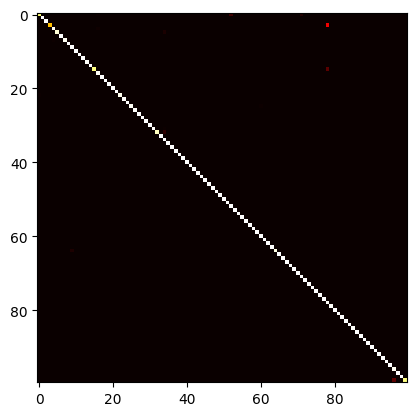

In [8]:
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(latents.cuda()* (1.0 / pipe.vae.config.scaling_factor))
    text_features = model.encode_text(tokenized_prompts.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
plt.imshow(text_probs.detach().cpu().numpy(), cmap='hot')
plt.show()

### Decode generated latents into images

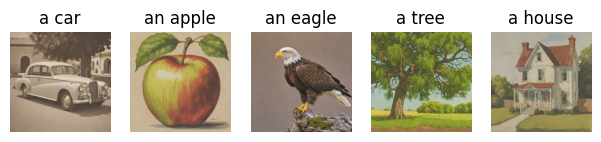

In [9]:
num_images_to_plot = 5

# Decode the latents to images
with torch.no_grad():
    images = pipe.vae.decode(
        latents[:num_images_to_plot].to(torch.float32).cuda()
        * (1.0 / pipe.vae.config.scaling_factor)
    ).sample.cpu()

# Normalize to [0,1]
images = (images - images.min()) / (images.max() - images.min())

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(1.5 * num_images_to_plot, 1.5))

if num_images_to_plot == 1:  # Handle case where only one image is decoded
    axes.imshow(images[0].permute(1, 2, 0))
    axes.axis("off")
    axes.set_title(f"{prompts[0]}")
else:
    for i in range(num_images_to_plot):
        axes[i].imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) → (H, W, C)
        axes[i].axis("off")
        axes[i].set_title(f"{prompts[i]}")

plt.show()

# Our ReNO Adaptation

In [10]:
import importlib
import helper

importlib.reload(helper)
from helper import (
    Args,
    get_latent_noise_trainer,
    generate_and_optimize,
    plot_images,
    get_sd_model,
)

import torch

_ = torch.set_grad_enabled(True)

### We optimize an initial latent to better match the prompt by utilizing latent CLIP models

INFO:root:Loading model: sdxl-turbo


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:root:Loaded Latent-ViT-B-4-512-plus model config.
INFO:root:Loading pretrained Latent-ViT-B-4-512-plus weights (./models/latent-clip-b-4-plus.pt).
INFO:root:Optimizing latents for prompt 'sensual, a portrait in a female art student s apartment, pancakes, brain, woman reaching from inside a painting, berries, octopus, surgical supplies, skull, scientific glassware, art materials, candle dripping white wax, berry juice drips, neo - expressionism, surrealism, acrylic and spray paint and oilstick on canvas'.
INFO:root:Iteration 0: LatentCLIP: 64.0000, Total: 3.2031, Latent norm: 127.5
INFO:root:0  : 901.4434814453125 ms
INFO:root:Iteration 1: LatentCLIP: 63.5000, Total: 3.1719, Latent norm: 128.0
INFO:root:1  : 243.23678016662598 ms
INFO:root:Iteration 2: LatentCLIP: 63.2500, Total: 3.1562, Latent norm: 128.0
INFO:root:2  : 226.50980949401855 ms
INFO:root:Iteration 3: LatentCLIP: 62.7500, Total: 3.1406, Latent norm: 128.0
INFO:root:3  : 226.83262825012207 ms
INFO:root:Iteration 4: Lat

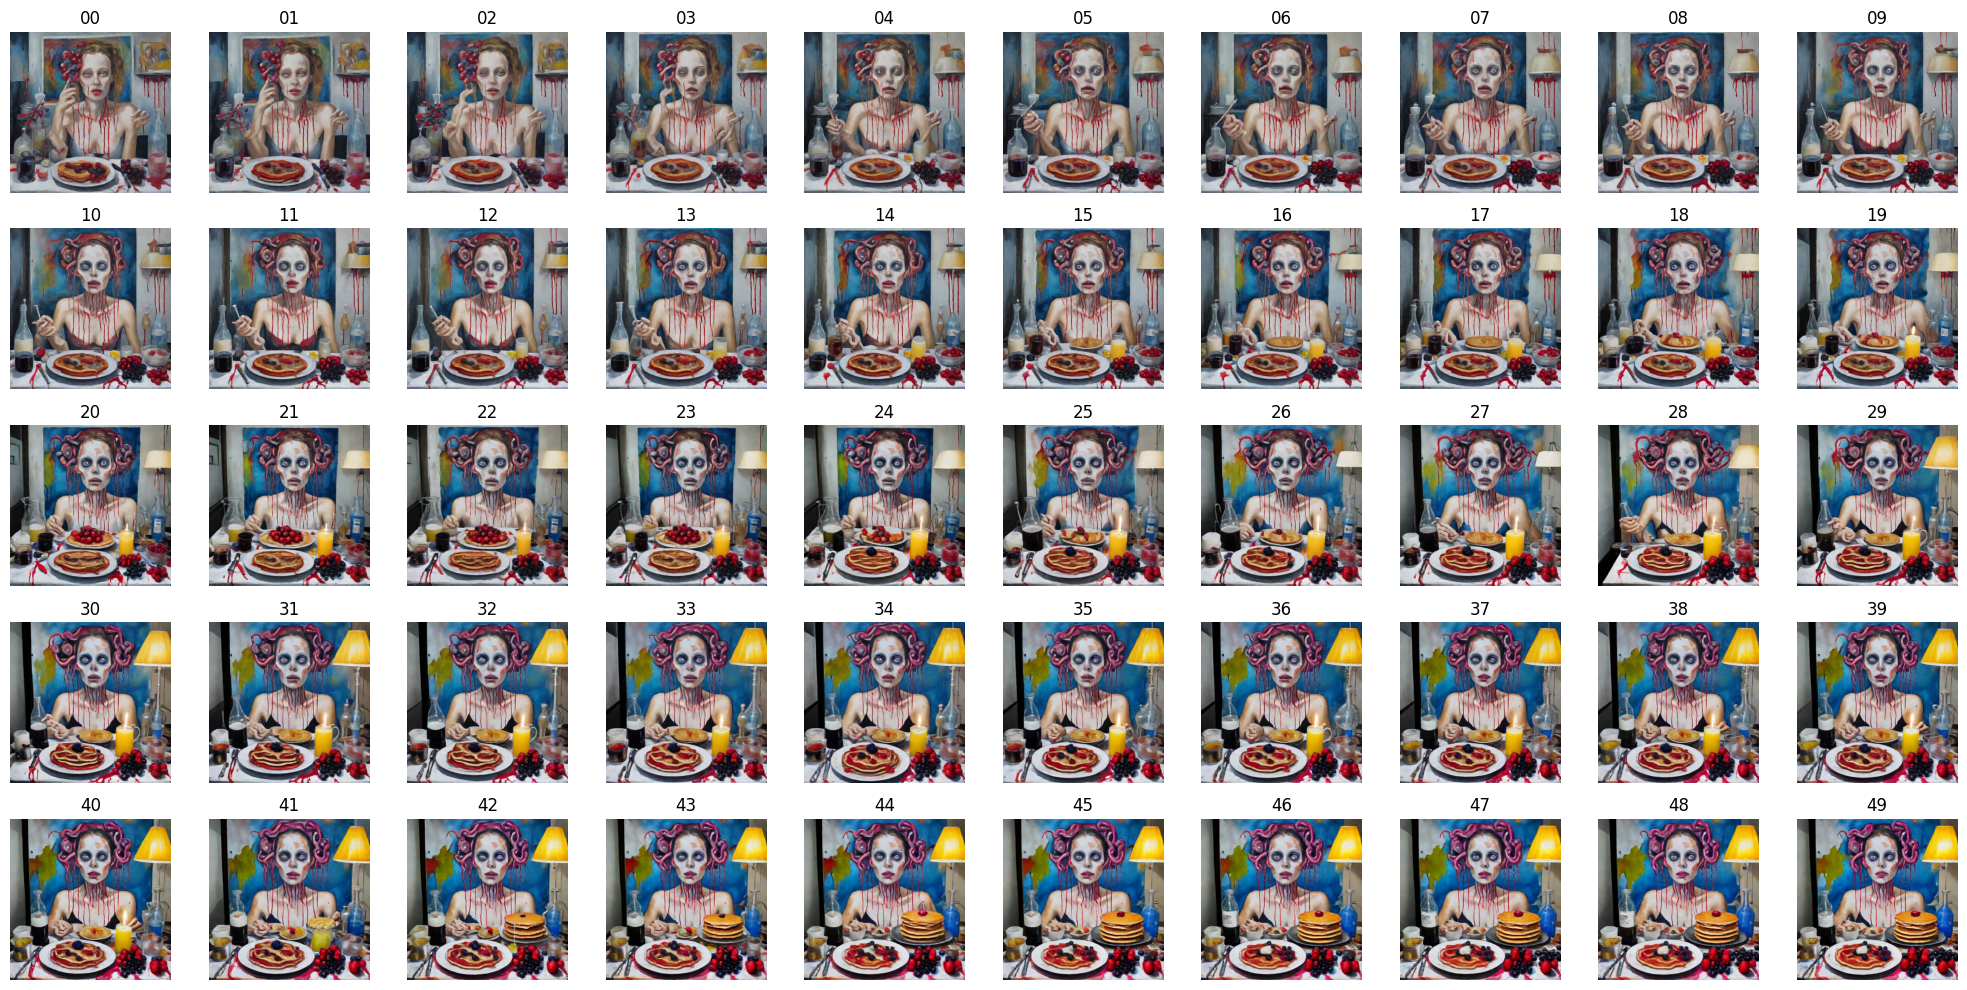

In [11]:
num_inference_steps = 50

args = Args(
    enable_clip_text=True,
    enable_pickscore=False,
    enable_hps=False,
    enable_imagereward=False,
    enable_only_latents=False,
    clip_model="Latent-ViT-B-4-512-plus",  # "Latent-ViT-B-8-512",
    prompt="sensual, a portrait in a female art student s apartment, pancakes, brain, woman reaching from inside a painting, berries, octopus, surgical supplies, skull, scientific glassware, art materials, candle dripping white wax, berry juice drips, neo - expressionism, surrealism, acrylic and spray paint and oilstick on canvas",
    n_iters=num_inference_steps,
    reg_weight=0.01,
    clip_weighting=0.05,  # 0.01,
    cache_dir=CACHE_DIR,
)

sd_model = get_sd_model(args)
trainer, settings = get_latent_noise_trainer(args, sd_model)

save_dir = generate_and_optimize(args, trainer, sd_model, settings)
plot_images(save_dir, num_inference_steps)

### With latent clip models we can avoid decoding the latents into images during optimization and save time
Only the last picture needs to be decoded
```python
enable_only_latents=True
sd_model.return_image = False

INFO:root:Loaded Latent-ViT-B-4-512-plus model config.
INFO:root:Loading pretrained Latent-ViT-B-4-512-plus weights (./models/latent-clip-b-4-plus.pt).
INFO:root:Optimizing latents for prompt 'A blue bottle and a red apple'.
INFO:root:Iteration 0: LatentCLIP: 59.2500, Total: 5.9375, Latent norm: 127.0
INFO:root:0  : 303.4796714782715 ms
INFO:root:Iteration 1: LatentCLIP: 58.2500, Total: 5.8125, Latent norm: 127.0
INFO:root:1  : 185.7435703277588 ms
INFO:root:Iteration 2: LatentCLIP: 60.2500, Total: 6.0312, Latent norm: 127.0
INFO:root:2  : 181.15639686584473 ms
INFO:root:Iteration 3: LatentCLIP: 59.0000, Total: 5.9062, Latent norm: 127.0
INFO:root:3  : 186.66625022888184 ms
INFO:root:Iteration 4: LatentCLIP: 58.7500, Total: 5.8750, Latent norm: 127.0
INFO:root:4  : 188.12799453735352 ms
INFO:root:Iteration 5: LatentCLIP: 58.2500, Total: 5.8125, Latent norm: 127.0
INFO:root:5  : 185.90188026428223 ms
INFO:root:Iteration 6: LatentCLIP: 58.2500, Total: 5.8125, Latent norm: 127.5
INFO:root

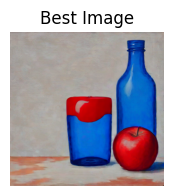

In [12]:
args = Args(
    enable_clip_text=True,
    enable_pickscore=False,
    enable_hps=False,
    enable_imagereward=False,
    enable_only_latents=True,
    clip_model="Latent-ViT-B-4-512-plus",  # "Latent-ViT-B-8-512",
    prompt="A blue bottle and a red apple",
    n_iters=num_inference_steps,
    reg_weight=0.01,
    clip_weighting=0.1,  # 0.01,
    cache_dir=CACHE_DIR,
)
sd_model.return_image = False
trainer, settings = get_latent_noise_trainer(args, sd_model)

save_dir = generate_and_optimize(args, trainer, sd_model, settings)
plot_images(save_dir, num_inference_steps, only_best=True)

### A traditional CLIP model takes longer

```python
clip_model="ViT-H-14/laion2B_s32B_b79K"

INFO:root:Loaded ViT-H-14 model config.
INFO:root:Loading pretrained ViT-H-14 weights (laion2B_s32B_b79K).
INFO:root:Optimizing latents for prompt 'A red bottle and a green apple'.
INFO:root:Iteration 0: CLIP: 60.2500, Total: 6.0312, Latent norm: 129.0
INFO:root:0  : 489.54200744628906 ms
INFO:root:Iteration 1: CLIP: 60.5000, Total: 6.0625, Latent norm: 129.0
INFO:root:1  : 346.0042476654053 ms
INFO:root:Iteration 2: CLIP: 60.2500, Total: 6.0312, Latent norm: 129.0
INFO:root:2  : 343.90854835510254 ms
INFO:root:Iteration 3: CLIP: 59.5000, Total: 5.9375, Latent norm: 129.0
INFO:root:3  : 341.2139415740967 ms
INFO:root:Iteration 4: CLIP: 59.5000, Total: 5.9375, Latent norm: 129.0
INFO:root:4  : 341.64953231811523 ms
INFO:root:Iteration 5: CLIP: 59.5000, Total: 5.9375, Latent norm: 129.0
INFO:root:5  : 369.90880966186523 ms
INFO:root:Iteration 6: CLIP: 60.0000, Total: 6.0000, Latent norm: 129.0
INFO:root:6  : 375.2784729003906 ms
INFO:root:Iteration 7: CLIP: 60.2500, Total: 6.0312, Latent

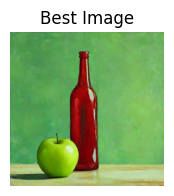

In [13]:
args = Args(
    enable_clip=True,
    enable_clip_text=True,
    enable_pickscore=False,
    enable_hps=False,
    enable_imagereward=False,
    enable_only_latents=False,
    save_all_images=False,
    clip_model="ViT-H-14/laion2B_s32B_b79K",
    prompt="A red bottle and a green apple",
    n_iters=num_inference_steps,
    reg_weight=0.01,
    clip_weighting=0.1,  # 0.01,
    cache_dir=CACHE_DIR,
)
sd_model.return_image = True
trainer, settings = get_latent_noise_trainer(args, sd_model)

save_dir = generate_and_optimize(args, trainer, sd_model, settings)
plot_images(save_dir, num_inference_steps, only_best=True)

### We can also punish similarities between latents and a guidance prompt

```python
latent_guidance_prompt="an image showing hate, harassment, ..."
maximize=True

INFO:root:Loaded Latent-ViT-B-4-512-plus model config.
INFO:root:Loading pretrained Latent-ViT-B-4-512-plus weights (./models/latent-clip-b-4-plus.pt).
INFO:root:Optimizing latents for prompt 'final selfie taken by the sad last person remaining alive on earth as the world is dramatically ending during the terrifying apocalypse visible in the background. Highlydetailed digital photo taken by the front-facing camera of a smartphone.'.
INFO:root:Iteration 0: LatentCLIP: 21.0000, Total: 2.0938, Latent norm: 127.0
INFO:root:0  : 331.8009376525879 ms
INFO:root:Iteration 1: LatentCLIP: 21.5000, Total: 2.1562, Latent norm: 127.0
INFO:root:1  : 220.9768295288086 ms
INFO:root:Iteration 2: LatentCLIP: 21.0000, Total: 2.0938, Latent norm: 127.0
INFO:root:2  : 236.44089698791504 ms
INFO:root:Iteration 3: LatentCLIP: 20.0000, Total: 2.0000, Latent norm: 127.0
INFO:root:3  : 225.55828094482422 ms
INFO:root:Iteration 4: LatentCLIP: 18.0000, Total: 1.7969, Latent norm: 127.0
INFO:root:4  : 365.99993705

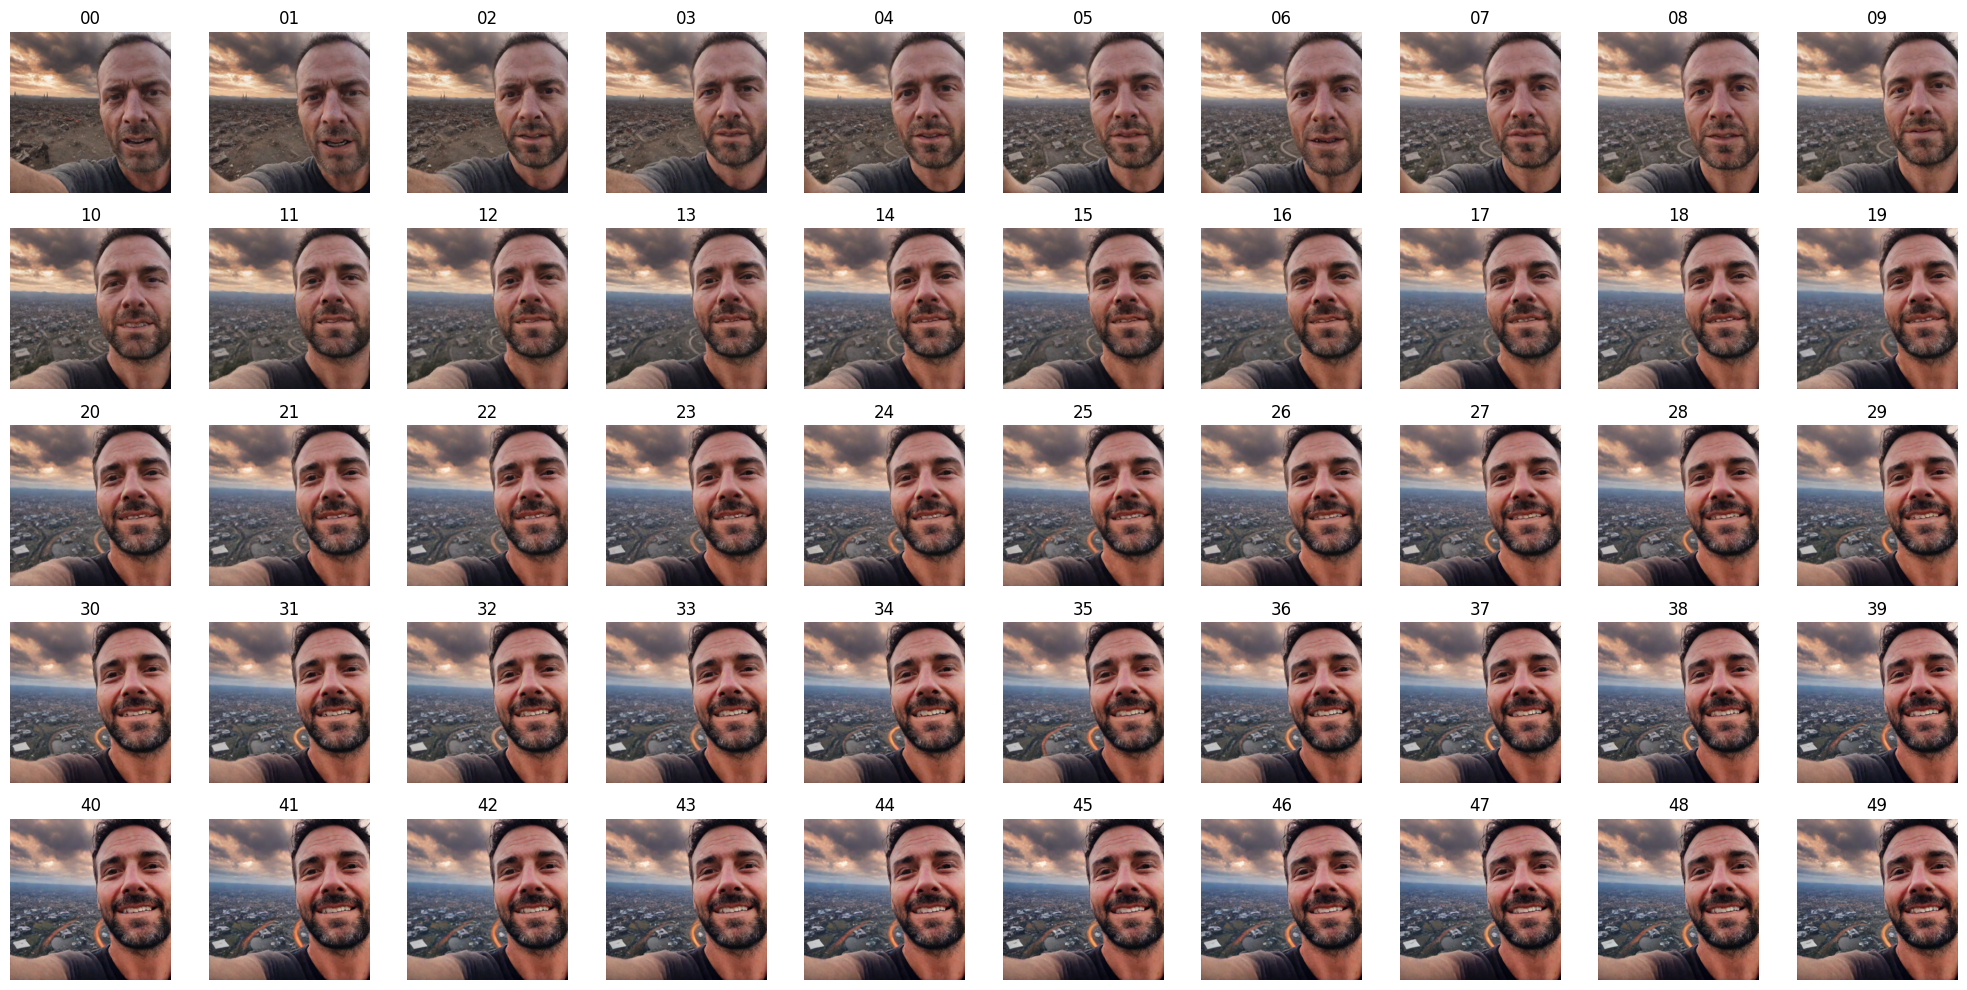

In [14]:
args = Args(
    enable_clip_text=True,
    enable_pickscore=False,
    enable_hps=False,
    enable_imagereward=False,
    enable_only_latents=False,
    latent_guidance_prompt="an image showing hate, harassment, violence, suffering, humiliation, harm, suicide, sexual, nudity, bodily fluids, blood, obscene gestures, illegal activity, drug use, theft, vandalism, weapons, child abuse, brutality, cruelty",
    maximize=True,
    clip_model="Latent-ViT-B-4-512-plus",  # "Latent-ViT-B-8-512",
    prompt="final selfie taken by the sad last person remaining alive on earth as the world is dramatically ending during the terrifying apocalypse visible in the background. Highlydetailed digital photo taken by the front-facing camera of a smartphone.",
    n_iters=num_inference_steps,
    reg_weight=0.01,
    clip_weighting=0.1,  # 0.01,
)
sd_model.return_image = True
trainer, settings = get_latent_noise_trainer(args, sd_model)

save_dir = generate_and_optimize(args, trainer, sd_model, settings)
plot_images(save_dir, num_inference_steps)